In [16]:
import pandas as pd
datos = pd.read_csv("/Users/jaimecastro/Desktop/Data science/datos_numéricos_target_grado.csv")

datos.head()


,Género,Grado,Cuando,Hipoxia,THBS1_ratio,APOH_ratio,APOA2_ratio,Triptasa_ratio,A2-AP_ratio,Edad_normalizada,...,Corticoesteroides,Epinefrina,Antagonistas HIST 1-2,Agonistas B2 adrenérgicos,Reaccion_clasificado_AINES,Reaccion_clasificado_Analgésicos y Antipiréticos,Reaccion_clasificado_Antibióticos,Reaccion_clasificado_Contrastes Radiológicos,Reaccion_clasificado_Otros medicamentos,Reaccion_clasificado_Quimioterapia
0,1.0,1.0,0.0,1,NaN,NaN,NaN,NaN,NaN,-0.766767,...,1,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,2.0,0.0,0,1.206289,1.083953,1.559585,1.725212,0.511112,-0.281246,...,1,1,1,0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,2.0,1.0,0,0.962169,0.905263,0.954955,0.691928,0.514807,-0.220556,...,1,1,1,0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,2.0,0.0,1,0.904459,0.958791,0.281800,2.081081,0.768910,0.507724,...,1,0,1,0,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,2.0,NaN,1,0.936709,0.737819,0.730120,NaN,0.741710,-0.888147,...,1,1,1,0,0.0,0.0,1.0,0.0,0.0,0.0


# Tratamos valores nulos por K

In [17]:
from sklearn.impute import KNNImputer

# Mostrar número de valores nulos por columna
print(datos.isnull().sum())

# Crear el imputador KNN
imputer = KNNImputer(n_neighbors=5)

# Imputar los valores nulos
data_imputed = imputer.fit_transform(datos)

# Convertir el resultado de vuelta a un DataFrame
datos_tratados = pd.DataFrame(data_imputed, columns=datos.columns)


# Verificar que ya no hay valores nulos
print(datos_tratados.isnull().sum())


Género                                               0
Grado                                                0
Cuando                                              18
Hipoxia                                              0
THBS1_ratio                                         74
APOH_ratio                                          79
APOA2_ratio                                         84
Triptasa_ratio                                      16
A2-AP_ratio                                         45
Edad_normalizada                                     0
Prurito y Eritema                                    0
Angioedema/Edema                                     0
Urticaria                                            0
Otros_tegumentario                                   0
Dolor abdominal-Náuseas                              0
Vómitos-Diarrea                                      0
Disfagia                                             0
Otros_digestivo                                      0
Tos-Estorn

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Asumiendo que la columna 'Grado' es nuestra variable objetivo
X = datos_tratados.drop('Grado', axis=1)
y = datos_tratados['Grado']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42)

# Crear el modelo Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenar el modelo
rf_model.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = rf_model.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

from sklearn.metrics import f1_score

# Calcular f1-score para cada clase y el promedio ponderado
f1_scores = f1_score(y_test, y_pred, average=None)
f1_score_weighted = f1_score(y_test, y_pred, average='weighted')

f1_scores, f1_score_weighted

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_rep)


Accuracy: 0.7
Classification Report:
              precision    recall  f1-score   support

         1.0       0.67      1.00      0.80        36
         2.0       0.70      0.58      0.64        48
         3.0       0.81      0.50      0.62        26

    accuracy                           0.70       110
   macro avg       0.73      0.69      0.69       110
weighted avg       0.72      0.70      0.69       110



# Validación cruzada modelo base


In [19]:
from sklearn.model_selection import cross_val_score

# Realizar validación cruzada
cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')

# Mostrar los resultados
print(f"Cross-validation accuracy scores: {cv_scores}")
print(f"Mean cross-validation accuracy: {cv_scores.mean()}")


Cross-validation accuracy scores: [0.59375    0.8125     0.80645161 0.80645161 0.64516129]
Mean cross-validation accuracy: 0.7328629032258065


# Ajuste de hiperparámetros 

In [20]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Definir el espacio de búsqueda de hiperparámetros
param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(
    rf_model, 
    param_distributions=param_distributions, 
    n_iter=100, 
    scoring='accuracy', 
    n_jobs=-1, 
    cv=5, 
    random_state=42
)

# Ajustar el modelo
random_search.fit(X, y)

# Mostrar los mejores parámetros
best_params = random_search.best_params_
print("Best parameters found: ", best_params)


/Users/jaimecastro/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
210 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/jaimecastro/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jaimecastro/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/Users/jaimecastro/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 637, in _validate_params
    validate_parameter_c

Best parameters found:  {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None, 'bootstrap': True}


# Modelo ajustado

In [23]:
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.model_selection import cross_val_score

# Entrenar el modelo ajustado
rf_model_tuned = random_search.best_estimator_
rf_model_tuned.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred_tuned = rf_model_tuned.predict(X_test)

# Evaluar el modelo ajustado
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
classification_rep_tuned = classification_report(y_test, y_pred_tuned)

# Calcular f1-score
f1_scores_tuned = f1_score(y_test, y_pred_tuned, average=None)
f1_score_weighted_tuned = f1_score(y_test, y_pred_tuned, average='weighted')

# Calcular f1-score de la validación cruzada
cv_f1_scores = cross_val_score(rf_model_tuned, X_train, y_train, cv=5, scoring='f1_weighted')
cv_f1_mean = cv_f1_scores.mean()
cv_f1_std = cv_f1_scores.std()

# Calcular la desviación estándar para precisión y recall usando validación cruzada
cv_precision_scores = cross_val_score(rf_model_tuned, X_train, y_train, cv=5, scoring='precision_weighted')
cv_recall_scores = cross_val_score(rf_model_tuned, X_train, y_train, cv=5, scoring='recall_weighted')

cv_precision_mean = cv_precision_scores.mean()
cv_precision_std = cv_precision_scores.std()

cv_recall_mean = cv_recall_scores.mean()
cv_recall_std = cv_recall_scores.std()

print(f"Tuned Accuracy: {accuracy_tuned}")
print("Tuned Classification Report:")
print(classification_rep_tuned)
print("Tuned f1-scores for each class:", f1_scores_tuned)
print("Tuned Weighted f1-score:", f1_score_weighted_tuned)
print(f"Cross-Validation Mean Precision: {cv_precision_mean:.4f} ± {cv_precision_std:.4f}")
print(f"Cross-Validation Mean Recall: {cv_recall_mean:.4f} ± {cv_recall_std:.4f}")
print(f"Cross-Validation Mean F1-Score: {cv_f1_mean:.4f} ± {cv_f1_std:.4f}")


/Users/jaimecastro/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Tuned Accuracy: 0.7818181818181819
Tuned Classification Report:
              precision    recall  f1-score   support

         1.0       0.73      1.00      0.85        36
         2.0       0.80      0.73      0.76        48
         3.0       0.88      0.58      0.70        26

    accuracy                           0.78       110
   macro avg       0.80      0.77      0.77       110
weighted avg       0.80      0.78      0.77       110

Tuned f1-scores for each class: [0.84705882 0.76086957 0.69767442]
Tuned Weighted f1-score: 0.7741399241928594
Cross-Validation Mean Precision: 0.6599 ± 0.0579
Cross-Validation Mean Recall: 0.6156 ± 0.0586
Cross-Validation Mean F1-Score: 0.6009 ± 0.0755


# Modelo ajustado 

In [24]:
from sklearn.model_selection import cross_val_score

# Realizar validación cruzada con el modelo ajustado
cv_accuracy_scores = cross_val_score(rf_model_tuned, X, y, cv=5, scoring='accuracy')
cv_precision_scores = cross_val_score(rf_model_tuned, X, y, cv=5, scoring='precision_weighted')
cv_recall_scores = cross_val_score(rf_model_tuned, X, y, cv=5, scoring='recall_weighted')
cv_f1_scores = cross_val_score(rf_model_tuned, X, y, cv=5, scoring='f1_weighted')

# Mostrar los resultados
print(f"Tuned cross-validation accuracy scores: {cv_accuracy_scores}")
print(f"Tuned mean cross-validation accuracy: {cv_accuracy_scores.mean()} ± {cv_accuracy_scores.std()}")

print(f"Tuned cross-validation precision scores: {cv_precision_scores}")
print(f"Tuned mean cross-validation precision: {cv_precision_scores.mean()} ± {cv_precision_scores.std()}")

print(f"Tuned cross-validation recall scores: {cv_recall_scores}")
print(f"Tuned mean cross-validation recall: {cv_recall_scores.mean()} ± {cv_recall_scores.std()}")

print(f"Tuned cross-validation F1 scores: {cv_f1_scores}")
print(f"Tuned mean cross-validation F1 score: {cv_f1_scores.mean()} ± {cv_f1_scores.std()}")


Tuned cross-validation accuracy scores: [0.625      0.78125    0.87096774 0.90322581 0.64516129]
Tuned mean cross-validation accuracy: 0.7651209677419355 ± 0.11363172230612359
Tuned cross-validation precision scores: [0.6686769  0.83333333 0.87903226 0.91149711 0.71182796]
Tuned mean cross-validation precision: 0.8008735108034768 ± 0.09466262605960145
Tuned cross-validation recall scores: [0.625      0.78125    0.87096774 0.90322581 0.64516129]
Tuned mean cross-validation recall: 0.7651209677419355 ± 0.11363172230612359
Tuned cross-validation F1 scores: [0.61953125 0.77591319 0.8734255  0.90312555 0.59482759]
Tuned mean cross-validation F1 score: 0.7533646143162948 ± 0.12680437712090545


# Curva ROC/AUC

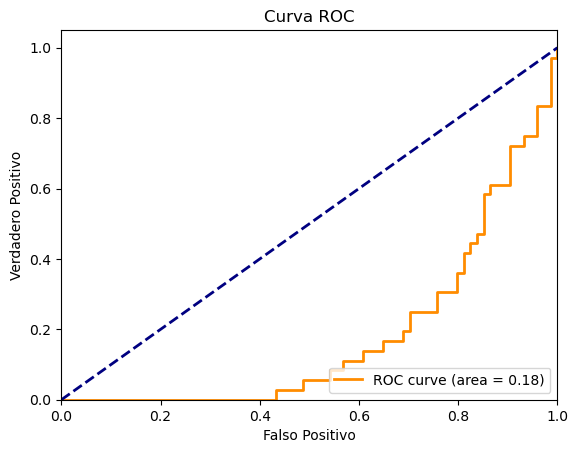

In [25]:
from sklearn.metrics import  roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt


y_pred_tuned = rf_model_tuned.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_tuned[:, 1], pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Falso Positivo')
plt.ylabel('Verdadero Positivo')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

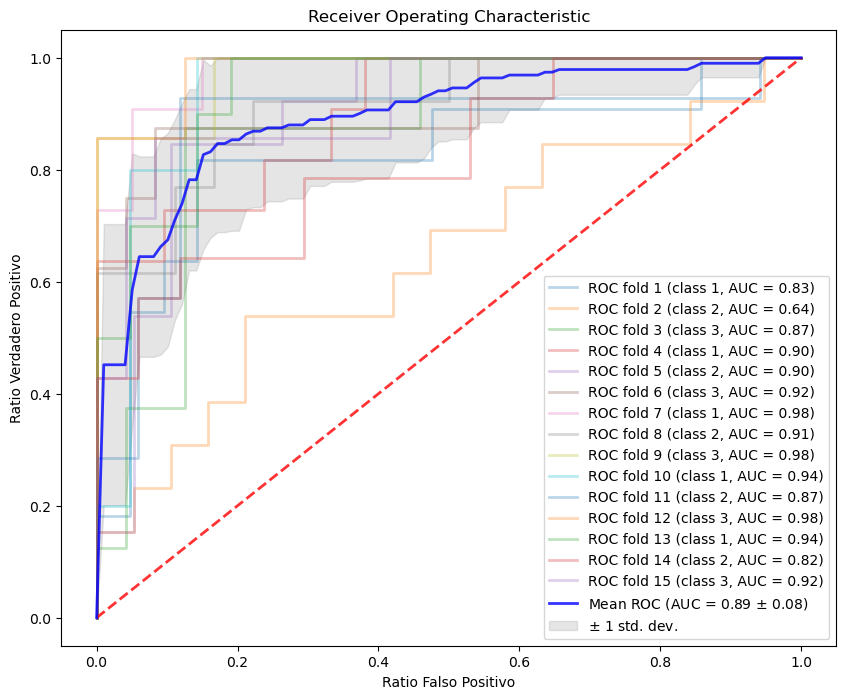

In [79]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import label_binarize
import numpy as np

# Binarizar las etiquetas para problemas multiclase
y_binarized = label_binarize(y, classes=[1, 2, 3])

# Realizar validación cruzada y obtener probabilidades de predicción
cv = StratifiedKFold(n_splits=5)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

plt.figure(figsize=(10, 8))

for train, test in cv.split(X, y):
    probas_ = rf_model_tuned.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])
    # Calcular la curva ROC y AUC para cada clase
    for i in range(3):
        fpr, tpr, _ = roc_curve(y_binarized[test][:, i], probas_[:, i])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=2, alpha=0.3, label=f'ROC fold {len(aucs)} (class {i+1}, AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Ratio Falso Positivo')
plt.ylabel('Ratio Verdadero Positivo')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# Importancia de las variables

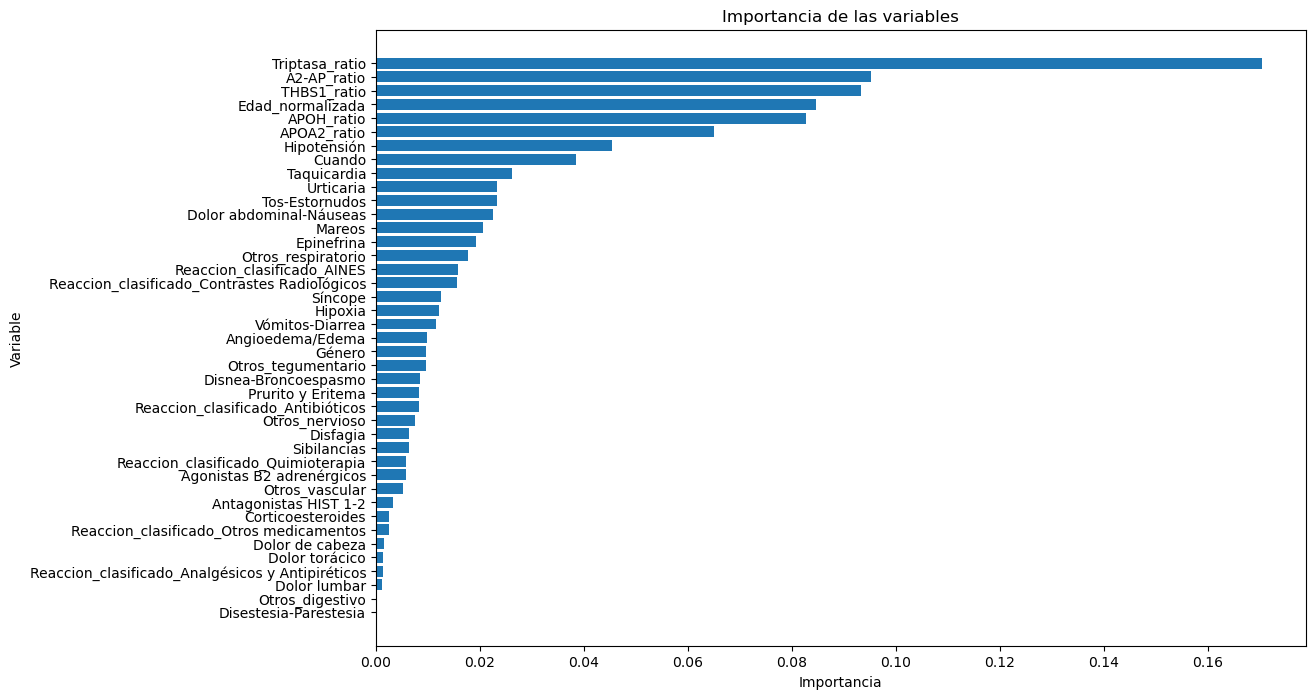

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Asegurarse de que el modelo Random Forest ajustado está entrenado
rf_model_tuned.fit(X_train, y_train)

# Obtener la importancia de las características
importances = rf_model_tuned.feature_importances_
indices = np.argsort(importances)[::-1]

# Obtener los nombres de las características
feature_names = X.columns

# Crear la gráfica
plt.figure(figsize=(12, 8))
plt.title("Importancia de las variables")
plt.barh(range(X.shape[1]), importances[indices], align="center")
plt.yticks(range(X.shape[1]), feature_names[indices])
plt.xlabel("Importancia")
plt.ylabel("Variable")
plt.gca().invert_yaxis()  # Invertir el eje Y para tener la característica más importante en la parte superior
plt.show()


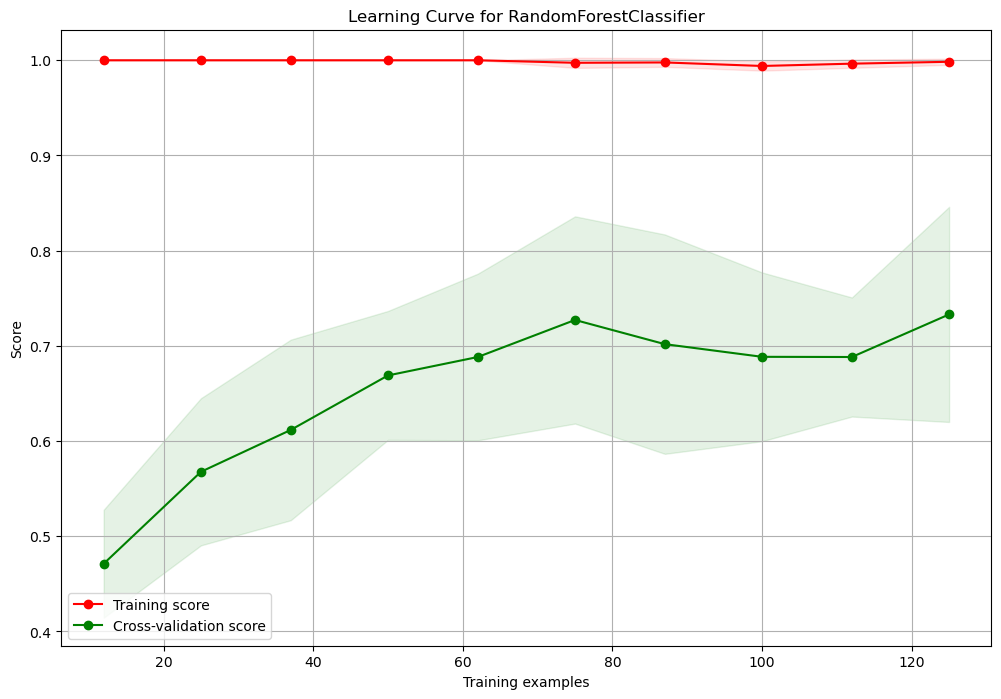

In [81]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
import numpy as np

# Definir el modelo
rf_model_tuned = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_features=best_params['max_features'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    bootstrap=best_params['bootstrap'],
    random_state=42
)

# Calcular la curva de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    rf_model_tuned, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
)

# Calcular la media y desviación estándar de las puntuaciones
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Graficar la curva de aprendizaje
plt.figure(figsize=(12, 8))
plt.title("Learning Curve for RandomForestClassifier")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()

# Graficar el área sombreada para la desviación estándar
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1,
                 color="g")

# Graficar las curvas de entrenamiento y prueba
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.legend(loc="best")
plt.show()
